# Bilderkennung mit PyTorch Lightning

In diesem Notebook trainieren wir unser erstes neuronales Netz. Wir folgen dabei dem ML-Ablauf, sammeln Erfahrungen mit Convolution Neuronal Netzwerken (siehe Theorieteil) und vertiefen unser Wissen mit Pytorch und Lightning.

*Tipp:* Für die Themen rund um PyTorch und Lightning wie zum Beispiel `DataSets`, `DataLoader` und `Trainer` kannst du dich am Notebook `AI_LinRegression` aus Woche 1 orientieren.

Hier nochmals zur Erinnerung der Ablauf beim Machine Learning:

1. Daten sammeln
2. Daten aufbereiten
3. Modell definieren & trainieren
4. Modell validieren
5. Modell optimieren
6. Modell benützen

Wie ihr an den folgenden Kapiteln sieht, gehen wir genau so vor.

*Tipp:* Klappe das Inhaltsverzeichnis auf, um dir einen Überblick zu verschaffen.

⚠️ **In diesem Notebook befinden sich Aufgaben. Ihr müsst die gelösten Aufgaben eurem Coach abgeben, damit sie bewertet werden.** ⚠️

Als erstes importieren wir die Packages welche wir brauchen und prüfen ob wir ein GPU zur verfügung haben:

In [279]:
import torch

print(f'Is GPU (Cuda) available: {torch.cuda.is_available()}')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('mps') if torch.mps.is_available() else torch.device("cpu")
print(torch.cuda.get_device_name(device=device))

Is GPU (Cuda) available: True
NVIDIA GeForce RTX 5080


## Daten sammeln

In diesem Notebook werden wir diese nicht selbst sammeln, sondern Daten verwenden, die es schon gibt.

Es gibt viele bekannten Datensets, welche kostenlos im Internet verfügbar sind. Eins davon ist die [MNIST-Datenbank mit handgeschriebenen Ziffern](https://de.wikipedia.org/wiki/MNIST-Datenbank). Dieses umfasst 60'000 kleine Schwarz/Weiss Bilder mit Grösse 28x28 Pixel, welche handgeschriebene Ziffern von 0 bis 9 zeigen. Wir begnügen uns mit einem Teil davon, erstmal 1'000, damit das Training schneller geht.

Du findest diese Bilder auf GitLab am gleichen Ort wie dieses Notebook unter `02_Homework\mnist_1k.zip`. Lade es herunter und entpacke das ZIP.

In [280]:
from pathlib import Path

# Pfad mit dem Ordner, wo die Bilder liegen. Ändere den Pfad, falls die Dateien bei dir an einem anderen Ort liegen.
image_directory_path = Path('./mnist_10k')

if not image_directory_path.exists():
    print(f"🛑 Fehler: Der Pfad ./mnist_10k/ existiert nicht. Entpacke das .zip file.")
else:
    print(f"Alles gut👍 der Pfad {image_directory_path} wurde gefunden")

Alles gut👍 der Pfad mnist_10k wurde gefunden


In [281]:
# Funktion, um alle Bilder im Ordner zu finden und als Path Objekte zurückzugeben
def get_image_paths(path: Path) -> list:
    return list(sorted(path.glob('**/*.png')))

In [282]:
# Alle Bilder-Pfade laden
image_paths = get_image_paths(image_directory_path)
print(f"Anzahl der Bilder: {len(image_paths)}")
# assert len(image_paths) == 1_000, "Es sollten 1_000 Bilder vorhanden sein"

Anzahl der Bilder: 9999


Nun schauen wir uns eines dieser Bilder an. Dazu benützen wir die Libraries `PIL` und `matplotlib`, welche ihr aus den Python Aufgaben kennt.

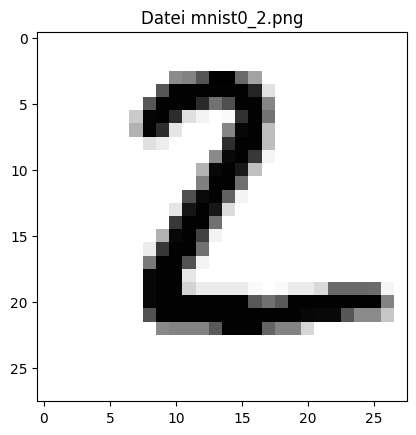

In [283]:
from PIL import Image
import matplotlib.pyplot as plt

# Ein Bild anzeigen
image_path = image_paths[0]
image = Image.open(image_path)
plt.imshow(image, cmap='gray')
plt.title(f"Datei {image_path.name}")
plt.show()

## Daten aufbereiten

Wir müssen die Daten so aufbereiten, dass PyTorch diese "versteht" und mit diesen arbeiten kann.

### Aufgabe 2.1

Aus dem Dateinamen können wir erkennen, welche Ziffer das Bild zeigt: `mnist<Index>_<Ziffer>.png`.

Erstelle also eine Funktion `get_label`, welche einen Dateipfad als `str` nimmt, die Ziffer aus dem Dateinamen extrahiert und als `int` zurückgibt.

Tipps:
- Du kannst eine Ziffer als Sting mit der Funktion `int` in eine Zahl umwandeln. Beispiel `int("9")`

In [284]:
# Funktion, welche aus dem Dateipfad das Label extrahiert
def get_label(path: str) -> int:
    pass

In [285]:
# SOLUTION

# Funktion, welche aus dem Dateipfad das Label extrahiert
def get_label(path) -> int:
    return int(Path(path).stem[-1])

In [286]:
# TESTS der Funktion get_label

test_path = "02_Homework/mnist_1k/mnist0_2.png"
assert get_label(test_path) == 2, "Fehler bei der Extraktion des Labels (2)"
test_path = "02_Homework/mnist_1k/mnist999_0.png"
assert get_label(test_path) == 0, "Fehler bei der Extraktion des Labels (0)"

Unser Target ist aber keine Nummer wie bei der Regression, sondern es gibt 10 Klassen, da wir 10 Ziffern (0-9) haben. Daher müssen wir eine Liste machen, wobei alle Werte auf 0 sind, ausser der Index der Ziffer ist 1. Diese Vorgehen nennt man auch ["one-hot encoding"](https://de.wikipedia.org/wiki/1-aus-n-Code)

Beispiel:

- Ziffer 0 = [1,0,0,0,0,0,0,0,0,0]
- Ziffer 1 = [0,1,0,0,0,0,0,0,0,0]
- Ziffer 9 = [0,0,0,0,0,0,0,0,0,1]


In [287]:
# On-hot encoding des Labels
def label_encoding(label: int) -> torch.Tensor:
    encoding = [0] * 10
    encoding[label] = 1
    return torch.tensor(encoding, dtype=torch.float32)

# Wenn wir schon dabei sind, das Selbe in die andere Richtung
# Wir geben das Label mit dem höchsten Wert zurück
def label_decoding(label: torch.Tensor) -> int:
    return label.argmax().item()

# TESTS label_encoding
assert label_encoding(0).tolist() == [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], "Fehler bei der Kodierung des Labels (0)"
assert label_encoding(4).tolist() == [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], "Fehler bei der Kodierung des Labels (9)"
assert label_decoding(torch.tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])) == 0, "Fehler bei der Dekodierung des Labels (0)"
assert label_decoding(torch.tensor([0, 0, 0, 0, 0.8, 0, 0, 0, 0, 0])) == 4, "Fehler bei der Dekodierung des Labels (9)"

### Aufgabe 2.2

Nun müssen wir noch einen `DataLoader` erstellen, welcher die Bilder einliest, und in ein Format bringen, welches das neuronale Netzwerk als Eingangsignal verwenden kann (Scaling). Letzteres bedeutet, die Pixelwerte, welche zwischen 0-255 liegen, auf einen Wert zwischen 0.0 und 1.0 bringen. Natürlich muss unser Dataset auch das Label zurückgeben.

Tipps:
- Orientiere dich am Dataloader im Notebook LinRegression von letzter Woche.
- Als Parameter in der `__init__` Methode wird eine Liste von Bildpfaden übergeben (das was aus `get_image_paths` herauskommt)
- Wichtig: Die Bilder sollen erst geladen werden, wenn sie benötigt werden (`__getitem__`). Ansonsten benützten wir zu viel Speicher
- In der `__getitem__` Methode wird folgendes gemacht:
  - Das Bild soll eingelesen werden (mit `Image.open`)
  - Das Bild soll in einen `float32` Tensor gewandelt werden (benützte dazu `pil_to_tensor`)
  - Danach muss der Tensor skaliert werden, sodass dessen Werte zwischen 0.0 und 1.0 liegen (teile dazu den Tensor einfach durch 255.0)
  - Das Label muss aus dem Bildpfad gelesen werden (`get_label`) und codiert werden (`label_encoding`)
  - Gebe anschliessend den Bild-Tensor und das codierte Label zurück (`tuple(tensor, label_encoded)`)
  - Schaue, dass du die alle anschliessenden Tests erfüllst


In [288]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

# Erstelle ein Dataset
class ImageDataset(Dataset):
    # Initialisierung des Datasets mit den Bildpfaden
    def __init__(self, image_paths):
        self.image_paths = image_paths

    # Gib die Länge des Datasets zurück
    def __len__(self):
        return len(self.image_paths)

    # Gebe das den Bild-Tensor und das encodierte Label für den Index idx zurück
    def __getitem__(self, idx):
        path = self.image_paths[idx]

        image = Image.open(path)

        image_tensor = pil_to_tensor(image)
        image_tensor = image_tensor / 255

        label = label_encoding(get_label(path))

        return image_tensor, label
        



In [289]:
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms.functional import pil_to_tensor

# Dataset, welches die Bilder und Labels enthält
# SOLUTION

class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    # Gib die Länge des Datasets zurück
    def __len__(self):
        return len(self.image_paths)

    # Lade das Bild und das Label-Encoding. Gebe ein Tuple (image, label) zurück
    def __getitem__(self, idx):
        path = self.image_paths[idx]
        
        image = Image.open(path)
        image_tensor = pil_to_tensor(image)
        image_tensor = image_tensor / 255.0 # Skaling
        
        label = get_label(path)
        label_encoded = label_encoding(label)
        
        return image_tensor, label_encoded

In [290]:
# TESTS ImageDataset

# Arrange (10 Bilder erstellen)
import tempfile
p = Path(tempfile.gettempdir()) / "test2-2"; p.mkdir(exist_ok=True)
images = [Image.new('L', (28, 28), int(25.5 * i)).save(p / f"mnist9{i}9_{i}.png") for i in range(10)]
test_image_paths = get_image_paths(p)

# Act
try:
    ImageDataset(test_image_paths)
except Exception as e:
    assert False, f"Es gab einen Fehler beim Erstellen des Datasets: {e}"
test_dataset = ImageDataset(test_image_paths)
assert len(test_dataset) == 10, "Die Länge des Datasets sollte 10 sein"
assert type(test_dataset[0]) is tuple, "Es sollte ein Tuple zurückgegeben werden"
assert len(test_dataset[0]) == 2, "Das zurückgegebene Tuple sollte 2 Elemente haben"
assert type(test_dataset[0][0]) is torch.Tensor, "Das erste Element des Tuples sollte ein Tensor sein"
assert test_dataset[0][0].shape == (1, 28, 28), "Der Image Tensor sollte die Shape (1, 28, 28) haben"
assert test_dataset[0][0].max() <= 1.0, "Die Werte des Image Tensors sollten zwischen 0 und 1 liegen"
assert test_dataset[0][0].min() >= 0.0, "Die Werte des Image Tensors sollten zwischen 0 und 1 liegen"
assert test_dataset[0][0].dtype == torch.float32, "Der Image Tensor sollte den Datentyp float32 haben"
assert type(test_dataset[0][1]) is torch.Tensor, "Das zweite Element des Tuples sollte ein Tensor sein"
assert test_dataset[0][1].shape == (10,), "Der Label Tensor sollte die Shape (10,) haben"

# Cleanup
import shutil; shutil.rmtree(p)

Nun müssen wir, wie wir gelernt haben, ein Trainings- und Validierungsset erstellen (split) und danach die `Datenloaders`

In [291]:
from torch.utils.data import DataLoader, random_split

# Wir erstellen unser Dataset
dataset = ImageDataset(image_paths)

# Wir werden 80% der Daten für das Training verwenden und 20% für das Validieren
train_dataset, val_dataset = random_split(dataset=dataset, lengths=[0.8, 0.2], generator=torch.Generator().manual_seed(3))
# (den generator benötigen wir nur, damit die Zufälligkeit reproduzierbar ist. In der Praxis lassen wir das weg)

# Überprüfen wir mal die Grösse dieser Sets
print(len(train_dataset), len(val_dataset))
# assert (len(train_dataset), len(val_dataset)) == (800, 200)

8000 1999


In [292]:
# Erstellen der DataLoaders
BATCH_SIZE = 128
training_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Ein Batch aus dem DataLoader laden und dessen Shape anzeigen
images, labels = next(iter(training_loader))
print(f"Input shape: {images.shape}")
print(f"Output shape {labels.shape}")

Input shape: torch.Size([128, 1, 28, 28])
Output shape torch.Size([128, 10])


### Aufgabe (Selbststudium)

<details>
  <summary>Überlege dir, was die einzelnen Zahlen Input Shape <code>[[128, 1, 28, 28]]</code> bedeuten? Klicke anschliessend auf den Pfeil, um die Lösung zu sehen.</summary>
    <br>Es gibt genau 4 Dimensionen in genau dieser Reihenfolge:
    <ul>
      <li>128: Die Batch-Size (also 128 Bilder pro Batch)</li>
      <li>1: Anzahl Farbkanäle. Da wir schwarz/weiss Bilder haben nur einer</li>
      <li>28: Höhe der Bilder in Pixel</li>
      <li>28: Breite der Bilder in Pixel</li>
    </ul> 
</details>

## Modell definieren & trainieren

Wir definieren nun unser Model, unser Trainer und sind schon bereit für unser Training

### Modell definieren

Wir versuchen es mal mit einem Dense Neuronal Netzwerk, dass heist vorerst mal ohne Convolution Layers.

Wie ein `LightningModule` aussieht und was die einzelnen Teile machen, solltest du aus dem `LinRegression` Notebook der letzten Woche wissen (und sonst schaue dort nach). Es werden nur noch neuen Sachen beschrieben! 

In [293]:
from lightning import LightningModule, Trainer


class DenseModel(LightningModule):
    # NEU Die Lernrate geben wir als Parameter mit, damit wir sie später einfach anpassen können
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        self.logged_metrics = {
            "train_loss": [],
            "val_loss": [],
        }
        
        # 2D Convolution-Layer mit 32 out neuronen und 3x3 kernel
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)

        # Max Pooling
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)

        # Dense Layer
        self.linear1 = torch.nn.Linear(14*14*32, 64)
        self.relu1 = torch.nn.ReLU()
        
        # Zum Schluss benötigen einen Layer wir 10 Neuronen als Output, da wir 10 Labels haben (Ziffern 0-9)
        # Als Input hat er die Anzahl Neuronen das Layers davor
        self.linear_out = torch.nn.Linear(64, 10)
        
        # Bei Klassifizierung verwenden wir als letztes die Softmax-Funktion, um für jeden Output eine Wahrscheinlichkeit zwischen 0..1 zu erhalten
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)

        x = x.flatten(start_dim=1)
        
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear_out(x)
        x = self.softmax(x)
        return x

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self(x)
        # Wichtig: Für Classification verwenden wir die CrossEntropyLoss Funktion
        loss = torch.nn.functional.cross_entropy(y_pred, y)
        self.logged_metrics["train_loss"].append(loss.item())
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self(x)
        # Wichtig: Für Classification verwenden wir die CrossEntropyLoss Funktion
        loss = torch.nn.functional.cross_entropy(y_pred, y)
        self.logged_metrics["val_loss"].append(loss.item())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [294]:
# Wir können uns ansehen, wie die Architektur des Modells aussieht.
# Hier sieht man die einzelnen Schichten, welche Ausgangssignale (Output Shape) sie erzeugen, sowie die Anzahl künstlicher Neuronen (Param #), welche sie enthalten.

from lightning.pytorch.callbacks import ModelSummary
ModelSummary().on_fit_start(Trainer(), DenseModel())

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | conv1      | Conv2d    | 320    | train
1 | pool1      | MaxPool2d | 0      | train
2 | linear1    | Linear    | 401 K  | train
3 | relu1      | ReLU      | 0      | train
4 | linear_out | Linear    | 650    | train
5 | softmax    | Softmax   | 0      | train
-------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.610     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Schaue die Architektur an und beantworte folgende Frage:

<details>
  <summary>Wie viele Gewichte müssen wir trainieren?</summary>
  
  `Total trainable params: 12.7k`  
  Also 12'700, eine ganze Menge... zum Glück müssen wir das nicht von Hand machen 😉

</details>

### Trainieren

Nun können wir unser Netzwerk trainieren. Wir geben dazu noch die Anzahl **Epochen** (komplette Durchläufe) an.

Das Training dauert eine Weile... 

In [295]:
# Anzahl Epochen definieren
EPOCHS = 250

# Trainer initialisieren. Diesmal benützten wir die GPU (falls keine verfügbar ist, kannst du auch 'cpu' verwenden)
trainer = Trainer(max_epochs=EPOCHS, accelerator='gpu')

# Modell initialisieren
LEARNING_RATE = 0.002
model = DenseModel(lr=LEARNING_RATE)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [296]:
%%time
# ⬆ Die Zeile "%%time" oben, sorgt dafür, dass unten angezeigt wird, wie lange es gedauert hat, diese Notebook Zelle auszuführen.
# Wir können somit sehen, wie lange das Training gedauert hat. Um die Resultate zu vergleichen, benützt du am besten 'CPU times' (und nicht 'Wall time').
# Wir definieren die Lernrate und die Anzahl Epochen für unser Training.

# Das Training starten. Dieses dauert eine Weile...
trainer.fit(model, training_loader, validation_loader)

# Unterhalb sehen wir den Vortschritt:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | conv1      | Conv2d    | 320    | train
1 | pool1      | MaxPool2d | 0      | train
2 | linear1    | Linear    | 401 K  | train
3 | relu1      | ReLU      | 0      | train
4 | linear_out | Linear    | 650    | train
5 | softmax    | Softmax   | 0      | train
-------------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.610     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/nico/source/ai-challange/ai-challange/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/nico/source/ai-challange/ai-challange/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


CPU times: user 2min 2s, sys: 9.36 s, total: 2min 12s
Wall time: 2min 9s


### Training anzeigen

Wir können uns den Verlauf des Trainings anzeigen lassen. Die Grafik unten zeigt uns, wie sich der Fehler (`loss`) während des Trainings entwickelt hat. Und zwar einmal beim Trainings-Set wie auch beim Validierungs-Set. Daraus können wir ablesen, ob es zu einem **Over/Underfitting** gekommen ist.

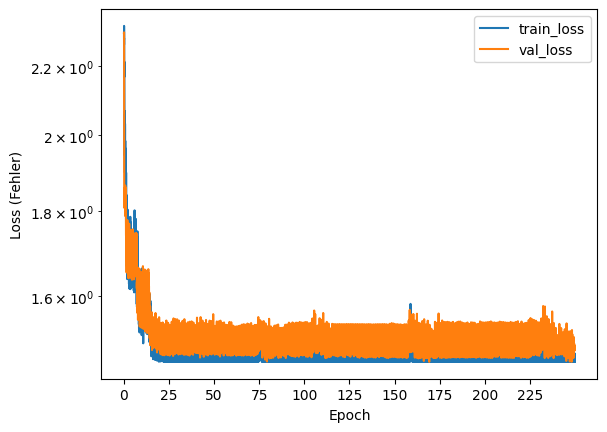

In [297]:
# Nun können wir uns die Trainings- und Validierungsfehler anschauen
train_loss = model.logged_metrics["train_loss"]
val_loss = model.logged_metrics["val_loss"]
plt.plot(train_loss, label="train_loss")
plt.plot(
    [int(i * (len(train_loss) / len(val_loss))) for i in range(len(val_loss))],
    val_loss,
    label="val_loss",
)
# Die X-Achse mit Epochs beschriften. Jedoch max 10 Beschriftungen
plt.xticks(
    ticks=[i * (len(train_loss) // 10) for i in range(10)],
    labels=[f"{i*(EPOCHS//10)}" for i in range(10)],
);
plt.xlabel("Epoch")
plt.ylabel("Loss (Fehler)")
plt.legend()

# Logarithmische Skala für die Y-Achse, da die Werte sehr gross sind
plt.yscale("log")

# Wir sehen, wie der Fehler immer geringer wird. Am Anfang schneller, wird die Kurve sehr flach
# Tipp: Schalte oben die logarithmische Skala ein, um die Kurve besser zu sehen!

Überprüfe die Lernkurve, kommt es zu Overfitting? Wenn Ja, reduziere die Anzahl Epochen

In [298]:
# Der Fehler am Ende des Trainings war:
print(f"Trainingsfehler: {train_loss[-1]:.3f}")
print(f"Validierungsfehler: {val_loss[-1]:.3f}")

Trainingsfehler: 1.461
Validierungsfehler: 1.489


### Eine Vorhersage machen

Damit wir nachher einfacher Vorhersagen machen können, bauen wir uns eine `predict` Funktion mit dem Model.

In [299]:
def predict(img_tensor):
    model.eval()
    with torch.no_grad():
        y_pred = model(img_tensor.unsqueeze(0))
    # Rückgabe ist das das Label, sowie die Wahrscheinlichkeiten für jedes Label
    return label_decoding(y_pred), y_pred[0].tolist()

# Testen wir unsere Funktion
image_tensor, _ = dataset[0]
pred_label, predict_props = predict(image_tensor)
print(f"Predicted label: {pred_label}")

Predicted label: 2


## Validieren

Wir schauen nun, wie gut unser Modell performt, also wie gut unser Modell mit noch nicht gesehenen Daten ist

Als erstes machen wir eine einzelne Vorhersage mit einem zufälligen Bild (du kannst die untere Zelle mehrmals ausführen und bekommst immer ein anderes Bild).

Wir betrachten insbesondere den Output des Modells. Schaue, dass du genau verstehst welche Werte aus dem Modell herauskommen und was diese bedeuten!

Vorhersage (Model output): [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]
Höchster Wert im Output an Index 8 (somit ist die Vorhersage diese Ziffer)
Das Modell ist sich dabei zu 100% sicher
Die Vorhersage ist korrekt 👍️


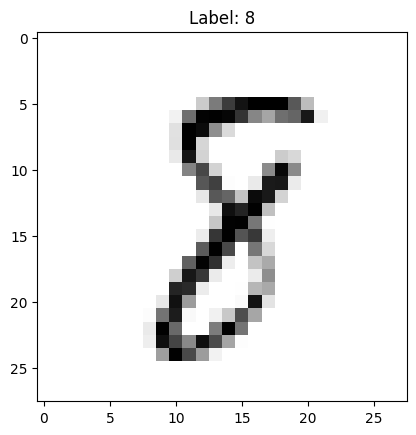

In [300]:
import random
from torchvision.transforms.functional import to_pil_image

# Wir laden ein zufälliges Bild/Label Paar
image_tensor, label_encoded = val_dataset[random.randint(0, len(val_dataset))]

# Wir plotten das Bild
image = to_pil_image(image_tensor)
plt.imshow(image, cmap='gray')
plt.title(f"Label: {label_decoding(label_encoded)}")

# Wir geben das Bild als Input in unser Modell
pred_label, pred_props = predict(image_tensor)

# Als ersten schauen wir uns den unformatierten Output des Modells an
print(f"Vorhersage (Model output): {[round(p, 2) for p in pred_props]}")

# Wir dekodieren die Vorhersage
print(f"Höchster Wert im Output an Index {pred_label} (somit ist die Vorhersage diese Ziffer)")

# Wir können uns auch anschauen, wie sicher sich das Modell ist (wie hoch die Wahrscheinlichkeit ist)
prediction_probability = pred_props[pred_label]
print(f"Das Modell ist sich dabei zu {prediction_probability:.0%} sicher")

# Wir prüfen, ob die Vorhersage korrekt ist
true_label = label_decoding(label_encoded)
correct = pred_label == true_label
print(f"Die Vorhersage ist {'korrekt 👍️' if correct else 'falsch 😿'}")

### Aufgabe (Selbststudium)

- Führe die Zelle oben mehrmals aus, bis du einen Fall findest, wo das Modell falsch liegt.

- Siehst du einen Grund dafür? Hättest du die Ziffer eindeutig erkannt?

- Verstehst du, was der Output des Models ist und wie es mit dem encoding/decoding (Stichwort: One-hot encoding von weiter oben) zusammenhängt?

Beantworte folgende Fragen:

<details>
  <summary>1. Warum ist der Output eine Liste und hat sie die Länge 10? Klicke auf den Pfeil, um die Lösung zu sehen.</summary>
    <br> Die Liste hat die Länge 10, da es genau 10 Output-Neuronen gibt - für jede Ziffer eins
</details>

<details>
  <summary>2. Was bedeuten die einzelnen Zahlen im Output?</summary>
    <br> Jeder Wert widerspiegelt die Wahrscheinlichkeit für diese Ziffer. Zusammen ergeben alle Zahlen immer 1.0 (dafür sorgt die SoftMax Funktion am Schluss unseres Netzwerkes).
    <br> Also wenn eine Stelle 1.0 ist und alle anderen 0.0, dann ist sich das Modell sehr sicher bei der Ziffer.
    <br> Und wenn ein Wert 0.51 ist und ein anderer 0.49, dann kann sich das Modell nicht zwischen diesen zwei Ziffer entscheiden.
    <br> Und wenn alle Werte 0.1 (1/10) haben, dann hat das Model keine Ahnung.
</details>


In der nächsten Zelle machen wir mehrere Vorhersagen und schauen uns ebenfalls das Bild dazu an.  
(Du kannst die Zelle ebenfalls mehrmals ausführen um neue Bilder zu erhalten.)

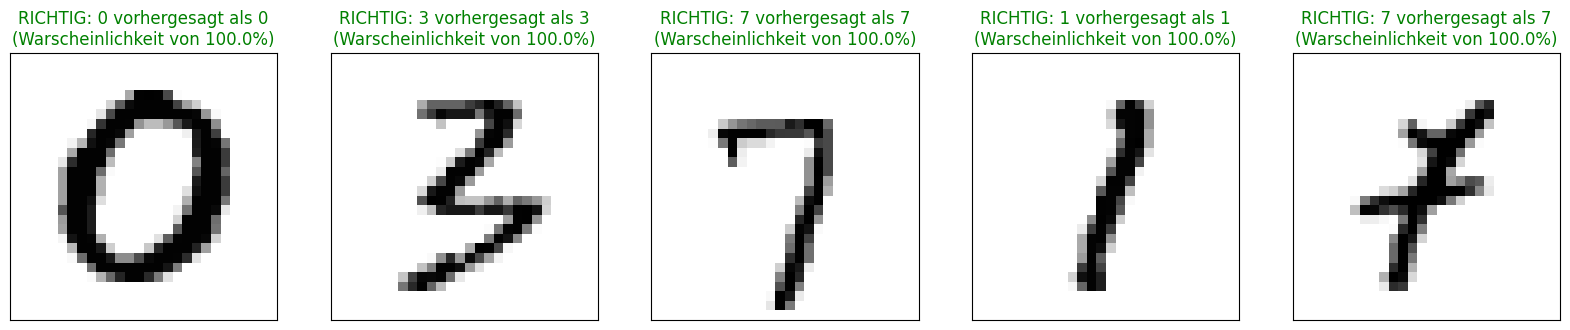

In [301]:
# Ein paar (zufällige) Vorhersagen aus dem Validationset machen.

model.eval()
with torch.no_grad():
    n = 5
    fig, axs = plt.subplots(1, n, figsize=(20, 4))
    axs = axs.flatten()
    for i, ax in enumerate(axs):
        image, label_encoded = val_dataset[random.randint(0, len(val_dataset))]
        label_decoded = label_decoding(label_encoded)
        prediction = model(image.unsqueeze(0))
        prediction_decoded = label_decoding(prediction)
        is_correct = 'RICHTIG' if label_decoded==prediction_decoded else 'FALSCH'
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(f"{is_correct}: {label_decoded} vorhergesagt als {prediction_decoded}\n(Warscheinlichkeit von {prediction.max().item():.1%})")
        ax.title.set_color('green' if label_decoded==prediction_decoded else 'red')
        # print(f"{'RICHTIG' if label_decoded==prediction_decoded else 'FALSCH'}\t Ziffer {label_decoded} vorhergesagt als Ziffer {prediction_decoded} mit einer Warscheinlichkeit von {prediction.max().item():.1%}")


### Metriken

Als nächste wollen wir einen Wert, um anzugeben wie gut unser Modell ist. Dafür eignet sich wie in der Theorie beschrieben die Accuracy (Genauigkeit). Diese gibt an, wie oft in Prozent das Modell richtig lag.

In [302]:
# Wir lassen und das gesamte Validation-Dataset durch das Modell laufen und die Vorhersagen machen
pred_labels = []
true_labels = []
correct = 0
for img_tensor, label_encoded in val_dataset:
    true_label = label_decoding(label_encoded)
    true_labels.append(true_label)
    pred_label = predict(img_tensor)[0]
    pred_labels.append(pred_label)
    if true_label == pred_label:
        correct += 1

# Wir berechnen die Genauigkeit
accuracy = correct / len(val_dataset)

print(f"Genauigkeit: {accuracy:.2%}")

Genauigkeit: 97.15%


Die Genauigkeit sollte bei ca. 50% liegen

### Confusion Matrix

Aber wo lag das Model richtig und wo hatte es Mühe?

Ein weitere wichtiges Hilfsmittel ist die sogenannte Confusion Matrix.
Diese zeigt den unterschied zwischen Vorhersage und echtem Label an.

Damit du verstehst, wie diese Funktioniert und wie sie zu lesen ist, schaue dir [diesen Artikel](https://databasecamp.de/ki/konfusionsmatrix) an (min. bis Kapitel 3.)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Predicted class', ylabel='True class'>)

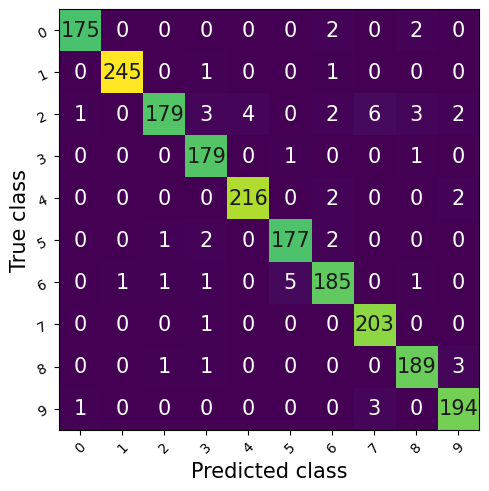

In [303]:
from torchmetrics import ConfusionMatrix

# Wir erstellen eine Confusion Matrix Funktion
confmat = ConfusionMatrix(task="multiclass", num_classes=10)

# Wir berechnen die Werte der Confusion Matrix
confusion_matrix = confmat(
    torch.tensor(pred_labels),
    torch.tensor(true_labels),
)

# Zum Schluss plotten wir die Confusion Matrix
confmat.plot()

Die Diagonale zeigt uns, wie oft wir richtig lagen (True == Predict)

An den anderen Felder, sehen wir, wo es häufig zu Verwechslungen kommt.

## Weitere Aufgaben

Bei den letzten zwei Aufgaben entwickelst du das neuronale Netz weiter, um die Genauigkeit zu erhöhen.

### Aufgabe 2.3

**Wichtig:** Mache eine Kopie dieses Notebooks um diese Aufgabe zu lösen.

Erweitere die `DenseNet` Klasse um einen lineare Layer und erhöhe die Anz. Neuronen im ersten Layer.
Die `__init__` Funktion sollte folgendes enthalten:

```python
    # Der erste Layer mit 128 anstatt 32 Neuronen
    self.linear1 = torch.nn.Linear(784, 128)
    self.relu1 = torch.nn.ReLU()

    # Ein neuer "hidden" Layer mit 64 Neuronen
    self.linear2 = torch.nn.Linear(128, 64)
    self.relu2 = torch.nn.ReLU()

    # Die Input-Size beim letzten Layer muss angepasst werden (== Output-Size des vorherigen Layers)
    self.linear_out = torch.nn.Linear(64, 10)
    self.softmax = torch.nn.Softmax(dim=1)
```

**Frage:** Was musst du in der `forward` Funktion ändern, damit die Layer auch benützt werden?
Layer und relu callen

**Frage:** Welche Genauigkeit erhältst du mit dem neuen Netzwerk? Und siehst du auch eine Verbesserung in der Confusion Matrix?
75.5% viel besser die Zahl 9 macht aber noch immer probleme

Wenn ich die Epochs erhöhe bewegt sich der error noch immer ziemlich genau immer etwas oberhalb des Training losses aber das model wird sehr gut am Ende mit circa 1000 Epochs

**Frage:** Wie viele Parameter müssen trainiert werden?
109k

### Aufgabe 2.3

**Wichtig:** Mache eine Kopie dieses Notebooks um diese Aufgabe zu lösen.

Baue nun die `DenseNet` Klasse zu einen Convolution Neuronal Network um, in dem du `Convoltion2D` Layer hinzufügst.

Die `__init__` Funktion sollte folgendes enthalten:

```python

        # Einen 2D Convolution-Layer mit 32 Neuronen und einen 3x3 Kernel
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        
        # Es folgt ein Max-Pooling, um die Datengrösse zu halbieren (von 28x28 auf 14x14)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Danach ein Dense Layer mit 64 Neuronen
        self.linear1 = torch.nn.Linear(14*14*32, 64)
        
        # Und unser Output-Layer
        self.relu1 = torch.nn.ReLU()
        self.linear_out = torch.nn.Linear(64, 10)
```

Die `forward` Funktion sollte so aussehen:

```python
    def forward(self, x):
        
        # Wichtig: Beim Eingang kein glätten mehr nötig, da wir Convolutional Layer verwenden, welcher 2-dimensional eBilder aufnimmt
        # x = x.view(-1, 784)
        
        x = self.conv1(x)
        x = self.pool1(x)
        
        # Aber nach dem Convolutional Layer müssen wir die Dimensionen wieder glätten
        x = x.flatten(start_dim=1)
        
        # Nach der Convolution folgt ein lineares Netzwerk
        x = self.linear1(x)
        x = self.relu1(x)
        
        # Und zum Schluss die Ausgabe
        x = self.linear_out(x)
        x = self.softmax(x)
        
        return x
```

**Frage:** Welche Genauigkeit erhältst du mit dem neuen Netzwerk? Und siehst du auch eine Verbesserung in der Confusion Matrix?


### Aufgabe (freiwillig)

- Verändere die Hyperparamter Lernrate, Batch-Size und Epochs. Kannst du eine bessere Genauigkeit erreichen oder das Training beschleunigen (gleiche Genauigkeit, aber in kürzere Zeit)?

- Kannst du die Genauigkeit mit mehr Daten erhöhen? Nehme dazu die Daten aus `mnist_10k.zip` (also 10x mehr Daten). Vermutlich musst du die Anzahl Epochen erhöhen, da man mit mehr Daten auch mehr lernen muss